# National Institute of Technology Karnataka Surathkal

## EC704 - VLSI Design Automation

## **Assignment 2**

## **MEMBERS**

- Inbasekaran Perumal : inba.201ec226@nitk.edu.in
- Meghna Uppuluri : meghna.201ec237@nitk.edu.in


## **_Course Instructor_**

- Dr. Ramesh Kini M.

## Git-hub link
https://github.com/the-pinbo/vlsi-cad/blob/main/Assignment-2/fm-algo.ipynb


In [1]:
#importing required libraries
from typing import Optional, List, Tuple, Set, DefaultDict, Dict, Any
from collections import defaultdict
import numpy as np
import random
import numpy.typing as npt
import graphviz as gv
import matplotlib.colors as mcolors

In [2]:
def initGraph(adjM: npt.NDArray[np.int64]) -> Tuple[DefaultDict[int, List[Tuple[int, int]]], int]:
    """Initializes adjacency list from the adjacency matrix and returns it along with the maximum gain value, which is the maximum possible gain for any individual move.

    Args:
        adjM (npt.NDArray[np.int64]): adjacency matrix representing the graph

    Returns:
        Tuple[DefaultDict[int, List[Tuple[int, int]]], int]: tuple of the adjacency list, which is in the form of the dictionary where keys are the vertices and values are the tuples containing the adjacent vertex and its corresponding edge weight, and the maximum gain value
    """
    MAX_GAIN = np.max(np.sum(adjM, axis=1))
    print(f"Max gain value: {MAX_GAIN}")
    print("Creating an AdjList")
    adjL: DefaultDict[int, List[Tuple[int, int]]] = defaultdict(list)
    for i in range(adjM.shape[0]):
        for j in range(i+1, adjM.shape[1]):
            if adjM[i][j] > 0:
                adjL[i].append((j, adjM[i][j]))
                adjL[j].append((i, adjM[i][j]))
    print(f"Adj list: {adjL}")

    return adjL, MAX_GAIN


def randomPartition(nodes: List[int]) -> Tuple[Set[int], Set[int]]:
    """randomly partitions the nodes into two sets, where each set represents a partition.

    Args:
        nodes (List[int]): list of nodes

    Returns:
        Tuple[Set[int], Set[int]]: two sets of partitioned nodes
    """
    # Debug
    # random.seed(3)
    random.shuffle(nodes.copy())
    midpoint = len(nodes) // 2
    return set(nodes[:midpoint]), set(nodes[midpoint:])


def inSameSet(u: int, v: int, a: Set[int], b: Set[int]) -> bool:
    """Checks whether two vertices are in the same partition

    Args:
        u (int): first vertex
        v (int): second vertex
        a (Set[int]): first partition
        b (Set[int]):second partition

    Returns:
        bool: true if both vertices are in the same partition, false otherwise
    """
    return u in a and v in a or u in b and v in b


def printBox(message: str, box_width: int = 100, ch: str = "#") -> None:
    box_border = ch * box_width
    message_padding = " " * ((box_width - len(message)) // 2)
    message_line = f"{ch}{message_padding}{message}{message_padding}{ch}#"
    print(box_border)
    print(message_line)
    print(box_border)


def initBucket(adjL: DefaultDict[int, List[Tuple[int, int]]], a: Set[int], b: Set[int], gain: DefaultDict[int, int], bucket_a: List[Set[int]], bucket_b: List[Set[int]]) -> int:
    """Initializes the gain of each vertex and the buckets for each gain value for both partitions of the graph

    Args:
        adjL (DefaultDict[int, List[Tuple[int, int]]]): adjacency list of the graph
        a (Set[int]): first partition
        b (Set[int]): second partition
        gain (DefaultDict[int, int]): dictionary containing the gain of each vertex
        bucket_a (List[Set[int]]): list of buckets, where each bucket is a set for the first partition
        bucket_b (List[Set[int]]): list of buckets, where each bucket is a set for the second partition

    Returns:
        int: initial cut size of the graph
    """
    cut_size: int = 0
    print("Initializing buckets")
    for u in adjL:
        for v, w in adjL[u]:
            if inSameSet(u, v, a, b):
                gain[u] -= w
            else:
                gain[u] += w
                cut_size += w
        if u in a:
            bucket_a[gain[u]].add(u)
        else:
            bucket_b[gain[u]].add(u)
    cut_size //= 2
    print(f"Initial gain: {gain}")
    print(f"Initial cut size: {cut_size}")
    print(f"Initial bucket_a: {bucket_a}")
    print(f"Initial bucket_b: {bucket_b}")
    return cut_size


def get_compliment_set(partition_set_label: str) -> str:
    """Returns the opposite set of the given partition set label

    Args:
        partition_set_label (str): label of the partition set

    Returns:
        str: label of the compliment set
    """
    return 'b' if partition_set_label == 'a' else 'a'


def find_maximum_gain_cells(bucket_a: List[Set[int]], bucket_b: List[Set[int]], size_dict: Dict[str, int], MAX_GAIN: int) -> Optional[Tuple[Set[int], str]]:
    """Finds and returns the cells with the highest gain value in the buckets from the smallest partition set. 
    If the ratio of the size of the smallest partition set to the total size of the graph is less than 0.5, then the cells with the highest gain value are returned from the smallest partition set.
    Otherwise, the cells with the highest gain value are returned from the largest partition set.

    Args:
        bucket_a (List[Set[int]]): list of buckets, where each bucket is a set for the first partition
        bucket_b (List[Set[int]]): list of buckets, where each bucket is a set for the second partition
        size_dict (Dict[str, int]): _description_
        MAX_GAIN (int): _description_

    Returns:
        Optional[Tuple[Set[int], str]]: tuple of the set of cells with the highest gain value and the partition set label
    """
    min_set = 'a' if size_dict['size_a'] < size_dict['size_b'] else 'b'
    size_min_set = size_dict[f'size_{min_set}']
    r = size_min_set/(size_dict['size_a']+size_dict['size_b'])
    print(f"ratio: {r}")
    epsilon = 0.01
    if abs(r-0.5) <= epsilon:
        for g in range(MAX_GAIN, -MAX_GAIN-1, -1):
            if bucket_a[g]:
                return bucket_a[g], 'a'
            if bucket_b[g]:
                return bucket_b[g], 'b'
    else:
        compliment_set = get_compliment_set(min_set)
        bucket = eval(f"bucket_{compliment_set}")
        for g in range(MAX_GAIN, -MAX_GAIN-1, -1):
            if bucket[g]:
                return bucket[g], compliment_set


def moveCellAndUpdate(adjL: DefaultDict[int, List[Tuple[int, int]]], u: int, a: Set[int], b: Set[int], gain: DefaultDict[int, int], cut_size: int, bucket_a: List[Set[int]], bucket_b: List[Set[int]], lock_cells_set: Set[int], max_gain_set_label: str):
    """Moves a single cell to the opposite partition set and updates the gains and buckets of vertices in the adjacency list. 
    The cell is moved to the partition set that contains the cell with the highest gain value. If the cell is locked, then it is not moved. 
    The gain of each vertex in the adjacency list of the cell is updated and the cell is added to the bucket of the partition set that it was moved to. 
    The cut size is updated by the gain of the cell. The cell is added to the set of locked cells.

    Args:
        adjL (DefaultDict[int, List[Tuple[int, int]]]): adjacency list of the graph
        u (int): vertex to be moved
        a (Set[int]): first partition
        b (Set[int]): second partition
        gain (DefaultDict[int, int]): dictionary containing the gain of each vertex
        cut_size (int): current cut size of the graph
        bucket_a (List[Set[int]]): list of buckets, where each bucket is a set for the first partition
        bucket_b (List[Set[int]]): list of buckets, where each bucket is a set for the second partition
        lock_cells_set (Set[int]): set of cells that are locked and cannot be moved
        max_gain_set_label (str): label of the partition set that contains the cell with the highest gain value

    """

    for v, w in adjL[u]:
        if v in lock_cells_set:
            continue
        old_bucket = eval(f'bucket_{max_gain_set_label}')
        new_bucket = eval(f'bucket_{get_compliment_set(max_gain_set_label)}')
        if inSameSet(u, v, a, b):
            old_bucket[gain[v]].remove(v)
            gain[v] += 2*w
            old_bucket[gain[v]].add(v)

        else:
            new_bucket[gain[v]].remove(v)
            gain[v] -= 2*w
            new_bucket[gain[v]].add(v)

    print('Cut size before moving cell: ', cut_size)
    print('Gain of cell before moving cell: ', gain[u])
    new_cut_size = cut_size - gain[u]
    gain.pop(u)

    old_cell_set = eval(f'{max_gain_set_label}')
    new_cell_set = eval(f'{get_compliment_set(max_gain_set_label)}')
    old_cell_set.remove(u)
    new_cell_set.add(u)
    print(f"old_cell_set: {old_cell_set}")
    print(f"new_cell_set: {new_cell_set}")
    print(f"gain: {gain}")
    print(f"bucket_a: {bucket_a}")
    print(f"bucket_b: {bucket_b}")
    print(f"old_cut_size: {cut_size}")
    print(f"new_cut_size: {new_cut_size}")
    return new_cut_size


def rollBackToBestCut(a: Set[int], b: Set[int], locked_cells: List[Tuple[int, Optional[int]]], MAX_GAIN: int) -> Tuple[int, Set[int], Set[int]]:
    """rolls back to the best cut by iterating over the locked cells in reverse order and moving the cell to the opposite partition set
    and updating the gains and buckets of vertices in the adjacency list.   

    Args:
        a (Set[int]): first partition
        b (Set[int]): second partition
        locked_cells (List[Tuple[int, Optional[int]]]): list of pairs containing the corresponding cut size and the cell that was locked
        MAX_GAIN (int): maximum gain value

    Raises:
        Exception: No vertex to rollback.
        
    Returns:
        Tuple[int, Set[int], Set[int]]: best cut size, corresponding first partition, corresponding second partition
    """
    min_cut: Tuple[int, Optional[int]] = (MAX_GAIN + 1, None)
    stack: List[Tuple[int, str]] = list()
    partition_a = a.copy()
    partition_b = b.copy()
    # Iterate over all locked cells in reverse order and roll back to the best cut
    for idx, (cut_size, u) in enumerate(locked_cells[-1: 0: -1]):
        if u is None:
            print("No vertex to rollback")
            raise Exception(
                "No vertex to rollback, something went wrong. Found None")
        print(
            f"Rolling back to cut size: {cut_size}, cell: {u}, idx: {idx},a: {partition_a}, b: {partition_b}")
        # Update min cut with along with the index of the cell that was locked
        min_cut = min(min_cut, (cut_size, idx))
        if u in partition_a:
            partition_a.remove(u)
            partition_b.add(u)
            stack.append((u, 'b'))
        else:
            partition_b.remove(u)
            partition_a.add(u)
            stack.append((u, 'a'))

    print(f"Min cut: {min_cut}")
    if min_cut[1] is None:
        print("No rollback")
    else:
        for _ in range(min_cut[1]):
            u, partition_label = stack.pop()
            remove_partition = eval(f'partition_{partition_label}')
            add_partition = eval(
                f'partition_{get_compliment_set(partition_label)}')
            remove_partition.remove(u)
            add_partition.add(u)

    return min_cut[0], partition_a, partition_b


def fmPass(adjL: DefaultDict[int, List[Tuple[int, int]]], a: Set[int], b: Set[int], area_dict: Dict[int, int], MAX_GAIN: int) -> Tuple[int, Set[int], Set[int]]:
    """Performs one pass of the FM algorithm by moving the cell with the highest gain value to the opposite partition set and updating the gains and buckets of vertices in the adjacency list. 

    Args:
        adjL (DefaultDict[int, List[Tuple[int, int]]]): adjacency list
        a (Set[int]): first partition
        b (Set[int]): second partition
        area_dict (Dict[int, int]): dictionary containing the area of each cell
        MAX_GAIN (int): maximum gain value

    Returns:
        Tuple[int, Set[int], Set[int]]: cut size, first partition, second partition
    """
    size_dict: Dict[str, int] = {'size_a': sum([area_dict[u] for u in a]), 'size_b': sum([
        area_dict[u] for u in b])}
    print(f"Initial size_dict: {size_dict}")
    gain: DefaultDict[int, int] = defaultdict(int)
    cut_size: int = 0
    bucket_a: List[Set[int]] = [set() for _ in range(2*MAX_GAIN+1)]
    bucket_b: List[Set[int]] = [set() for _ in range(2*MAX_GAIN+1)]
    cut_size = initBucket(adjL, a, b, gain, bucket_a, bucket_b)
    if len(adjL.keys()) == 2:
        printBox("Completed FM pass cant be broken down further")
        print("set a: ", a)
        print("set b: ", b)
        print("Cut size: ", cut_size)
        return cut_size, a, b
    locked_cells: List[Tuple[int, Optional[int]]] = [(cut_size, None)]
    lock_cells_set = set()
    while len(locked_cells)-1 < len(adjL.keys()):
        max_gain_cells = find_maximum_gain_cells(
            bucket_a, bucket_b, size_dict, MAX_GAIN)
        if not max_gain_cells:
            print("Could not find max gain cells")
            break

        max_gain_set, max_gain_set_label = max_gain_cells

        print(f"max_gain_set: {max_gain_set}")
        print(f"max_gain_set_label: {max_gain_set_label}")
        u = max_gain_set.pop()
        print(
            f"Moving cell {u} from {max_gain_set_label} to {get_compliment_set(max_gain_set_label)}")
        cut_size = moveCellAndUpdate(
            adjL, u, a, b, gain, cut_size, bucket_a, bucket_b, lock_cells_set, max_gain_set_label)
        area_dict[u]

        size_dict[f'size_{max_gain_set_label}'] -= area_dict[u]
        size_dict[f'size_{get_compliment_set(max_gain_set_label)}'] += area_dict[u]

        locked_cells.append((cut_size, u))
        print(f"locked_cells: {locked_cells}")
        lock_cells_set.add(u)
    min_cut, best_a, best_b = rollBackToBestCut(a, b, locked_cells, MAX_GAIN)
    printBox("Completed FM pass")
    print(f"min_cut(tuple[Any, int]) : {min_cut}")
    print(f"best_a: {best_a}")
    print(f"best_b: {best_b}")
    return min_cut, best_a, best_b


def fm(adjL: DefaultDict[int, List[Tuple[int, int]]], MAX_GAIN: int, area_dict: Dict[int, int], fm_passes: int = 1):
    """Performs the FM algorithm on the given graph. 

    Args:
        adjL (DefaultDict[int, List[Tuple[int, int]]]): adjacency list
        MAX_GAIN (int): maximum gain value
        area_dict (Dict[int, int]): dictionary containing the area of each cell
        fm_passes (int, optional): number of FM passes. Defaults to 1.

    Returns:
        _type_: min cut size, first partition, second partition
    """
    nodes = list(adjL.keys())
    print(f"Nodes:{nodes}")
    a, b = randomPartition(nodes)
    min_cut = MAX_GAIN + 1
    print(f"Partitioning the nodes into two sets.\na->{a}\nb->{b}")
    for i in range(fm_passes):
        printBox(f"FM pass: {i}")
        best_cut, a, b = fmPass(adjL, a, b, area_dict, MAX_GAIN)
        if best_cut >= min_cut:
            print("No improvement in this FM pass.")
            break

        min_cut = best_cut

    printBox("Completed FM")
    print("Final results")
    print("Number of FM passes: ", fm_passes)
    print(f"Final min_cut: {min_cut}")
    print(f"Final a partition: {a}")
    print(f"Final b partition: {b}")

    return min_cut, a, b


def pruneAdjL(adjL: DefaultDict[int, List[Tuple[int, int]]], partition_set: Set[int]) -> Tuple[DefaultDict[int, List[Tuple[int, int]]], int]:
    """Prune the adjacency list by removing the nodes in the partition set.

    Args:
        adjL (DefaultDict): adjacency list of the graph
        partition_set (Set): set of nodes in the partition

    Returns:
        Tuple[DefaultDict, int]: pruned adjacency list and
    """
    adjL = adjL.copy()
    MAX_GAIN = 0
    for u in partition_set:
        adjL.pop(u)
    for u in adjL.keys():
        adjL[u] = [(v, w) for v, w in adjL[u] if v not in partition_set]
        MAX_GAIN = max(MAX_GAIN, sum([w for _, w in adjL[u]]))

    return adjL, MAX_GAIN


def pruneAreaDict(area_dict: Dict[int, int], partition_set: Set[int]) -> Dict[int, int]:
    """Prune the area dictionary by removing the nodes in the partition set. 
    """
    area_dict = area_dict.copy()
    for u in partition_set:
        area_dict.pop(u)
    return area_dict


def fmRecursive(adjL: DefaultDict[int, List[Tuple[int, int]]], MAX_GAIN: int, area_dict: Dict[int, int], fm_passes: int = 1) -> Tuple[Any, int]:
    """Performs the FM algorithm on the given graph. It recursively applies the algorithm to each set until the sets contain only one node. 
    The final partition is the union of the partitions of the two sets. The cut size is the sum of the weights of the edges connecting the two sets.

    Args:
        adjL (DefaultDict[int, List[Tuple[int, int]]]): adjacency list
        MAX_GAIN (int): maximum gain value
        area_dict (Dict[int, int]): dictionary containing the area of each cell
        fm_passes (int, optional): number of FM passes. Defaults to 1.

    Returns:
        Tuple[Any, int]: partition, minimum cut size
    """

    if len(area_dict) == 1:
        single_partition_cut_tuple: Tuple[Tuple[int], int] = (
            tuple(area_dict.keys()), MAX_GAIN+1)
        return single_partition_cut_tuple

    best_cut, a, b = fm(adjL, MAX_GAIN, area_dict, fm_passes)

    printBox(f"Recursive call for a -> {a}", box_width=120, ch='<')
    adjL_a, MAX_GAIN_A = pruneAdjL(adjL, b)
    area_dict_a = pruneAreaDict(area_dict, b)
    partition_a, best_cut_a = fmRecursive(
        adjL_a, MAX_GAIN_A, area_dict_a, fm_passes)
    printBox(
        f"End of recursive call for a -> {a} partition_a -> {partition_a}, best_cut_a -> {best_cut_a}", box_width=120, ch='<')

    printBox(f"Recursive call for b -> {b}", box_width=120, ch='>')
    adjL_b, MAX_GAIN_B = pruneAdjL(adjL, a)
    area_dict_b = pruneAreaDict(area_dict, a)
    partition_b, best_cut_b = fmRecursive(
        adjL_b, MAX_GAIN_B, area_dict_b, fm_passes)
    printBox(
        f"End of recursive call for b -> {b} partition_b -> {partition_b}, best_cut_b -> {best_cut_b}", box_width=120, ch='>')

    partition: Tuple[Any, Any] = (
        (partition_a, best_cut_a), (partition_b, best_cut_b))

    printBox(f"Final Partition -> {partition}")

    return partition, best_cut


AttributeError: module 'numpy.typing' has no attribute 'NDArray'

In [ ]:
# Reading input
def readInput(input1:str,input2: str)-> Tuple[np.ndarray, Dict[int, Dict[str, int]], Dict[int, int]]:
    with open(input1, 'r') as file:
        input1_data = file.read()

    with open(input2, 'r') as file:
        input2_data = file.read()

    input1_data = eval(input1_data.replace(' ', '').replace('\n', '').replace('{', '(').replace('}', ')'))
    adjM = np.array([eval('['+row.strip().replace(' ', ',')+']')for row in input2_data.strip()[1:-1].split('\n')])

    blocks_dimension = {idx:{'width':width,'height':height} for idx, (width, height) in enumerate(input1_data[1:])}
    area_dict = {idx:width*height for idx, (width, height) in enumerate(input1_data[1:])}
    return adjM, blocks_dimension, area_dict

# GraphVisualization
def get_color(block_id: int)-> str:
    # Create a random color based on the block_id
    random.seed(block_id)
    r, g, b = random.random(), random.random(), random.random()
    color_str = mcolors.rgb2hex((r, g, b))
    return color_str

def getEdgeList(adjL:DefaultDict[int, List[Tuple[int, int]]])-> List[Tuple[int, int, int]]:
    """Takes inpput adjacency list and returns a list of tuples representing the edges of the graph.

    Args:
        adjL (DefaultDict[int, List[Tuple[int, int]]]): adjacency list

    Returns:
        List[Tuple[int, int, int]]: list of edges
    """
    edge_list = []
    seen = set()
    for u in adjL.keys():
        seen.add(u)
        for v, w in adjL[u]:
            if v not in seen:
                edge_list.append((u, v, w))
    return edge_list

def drawBlockRecursive(graph:gv.Graph,block: Tuple[Tuple, int], blocks_dimension: Dict[int, Dict[str, int]])->gv.Graph:
    """takes in a graph and a block and draws the blocks on the graph recursively.

    Args:
        graph (gv.Graph): graph object
        block (Tuple[Tuple, int]): block
        blocks_dimension (Dict[int, Dict[str, int]]): dimensions of each block

    Returns:
        gv.Graph: modified graph object
    """
    partition, best_cut = block
    if len(partition) == 1:
        block_id:int = partition[0]
        color = get_color(block_id)
        width = blocks_dimension[block_id]['width']
        height = blocks_dimension[block_id]['height']
        block_label = str(block_id)
        graph.node(block_label, f'{block_id}\n{width}x{height}\nbest_cut={best_cut}', 
                   width=f'{width//5}', height=f'{height//5}', color=color)
        return graph
    else:
        left_block, right_block = partition
        with graph.subgraph(name=f'cluster_{left_block[0]}') as c:
            drawBlockRecursive(c, left_block, blocks_dimension)
            color = get_color(id(left_block))
            c.attr(label=f'cluster_{left_block[0]}\nbest_cut={best_cut}', color=color)
            
        with graph.subgraph(name=f'cluster_{right_block[0]}') as c:
            drawBlockRecursive(c, right_block, blocks_dimension)
            color = get_color(id(right_block))
            c.attr(label=f'cluster_{right_block[0]}\nbest_cut={best_cut}', color=color)
        return graph
        
def drawBlocks(adjL,block: Tuple[Tuple, int], blocks_dimension: Dict[int, Dict[str, int]],filename:str='block',name:str='block',format:str='svg')->gv.Graph:
    """creates a graph object and draws the blocks and its children recursively using the 'drawBlockRecursive' function and add the edges to it.

    Args:
        adjL (_type_): adjacency list
        block (Tuple[Tuple, int]): block
        blocks_dimension (Dict[int, Dict[str, int]]): dimensions of each block
        filename (str, optional): . Defaults to 'block'.
        name (str, optional): . Defaults to 'block'.
        format (str, optional): Defaults to 'svg'.

    Returns:
        gv.Graph: graph object
    """
    g = gv.Graph(name='block', format='png', engine='fdp',node_attr={'shape': 'rectangle'},filename='block')
    g = drawBlockRecursive(g, block, blocks_dimension)
    edge_list = getEdgeList(adjL)
    for u, v, w in edge_list:
        g.edge(str(u), str(v), label=str(w))
    return g
    
    

In [ ]:
def main(input1,input2):
    adjM, blocks_dimension, area_dict = readInput(input1, input2)
    adjL, MAX_GAIN = initGraph(adjM)
    del adjM
    block = fmRecursive(adjL, MAX_GAIN, area_dict, 3)
    partition, best_cut = block
    printBox("FINAL PARTITIONS",ch='=', box_width=120)
    print("Partition:", partition)
    print("Best cut", best_cut)
    grpah = drawBlocks(adjL,block, blocks_dimension)
    grpah.view()
    grpah.render()
    grpah.save()
    return block, grpah
    

Max gain value: 12
Creating an AdjList
Adj list: defaultdict(<class 'list'>, {0: [(1, 1), (2, 3), (3, 2), (4, 4), (5, 2)], 1: [(0, 1), (2, 3), (3, 1), (4, 2), (5, 1)], 2: [(0, 3), (1, 3), (3, 1), (4, 1), (5, 2)], 3: [(0, 2), (1, 1), (2, 1), (4, 2), (5, 3)], 4: [(0, 4), (1, 2), (2, 1), (3, 2), (5, 1)], 5: [(0, 2), (1, 1), (2, 2), (3, 3), (4, 1)]})
Nodes:[0, 1, 2, 3, 4, 5]
Partitioning the nodes into two sets.
a->{0, 1, 2}
b->{3, 4, 5}
####################################################################################################
#                                             FM pass: 0                                             ##
####################################################################################################
Initial size_dict: {'size_a': 150, 'size_b': 66}
Initializing buckets
Initial gain: defaultdict(<class 'int'>, {0: 4, 1: 0, 2: -2, 3: -1, 4: 4, 5: 1})
Initial cut size: 16
Initial bucket_a: [{1}, set(), set(), set(), {0}, set(), set(), set(), set(), set(),

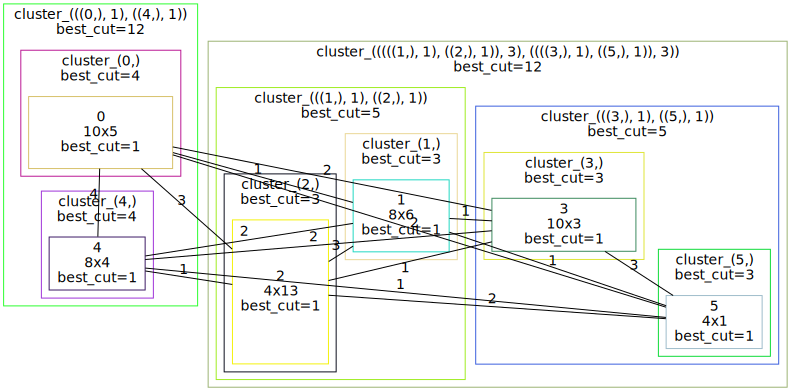

In [ ]:
input1 = './input_1.txt'
input2 = './input_2.txt'
block, grpah = main(input1,input2)
grpah